In [45]:
!pip install pydotplus
!pip install wandb --upgrade
!wandb login 781f7c7b2dfd11fb00abd252a1ea8eaba7e2a17d
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
import pydotplus 
import math
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils import np_utils
import wandb
from wandb.keras import WandbCallback
import os
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pacific_timezone = pytz.timezone("US/Pacific")
utc_timezone = pytz.timezone("UTC")


Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.31)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
data_train = pd.read_csv('adult_train.csv', sep=';')
data_test = pd.read_csv('adult_test.csv', sep=';')

In [0]:
#Cleaning Data
# Remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

In [6]:
#Data Wrangling
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

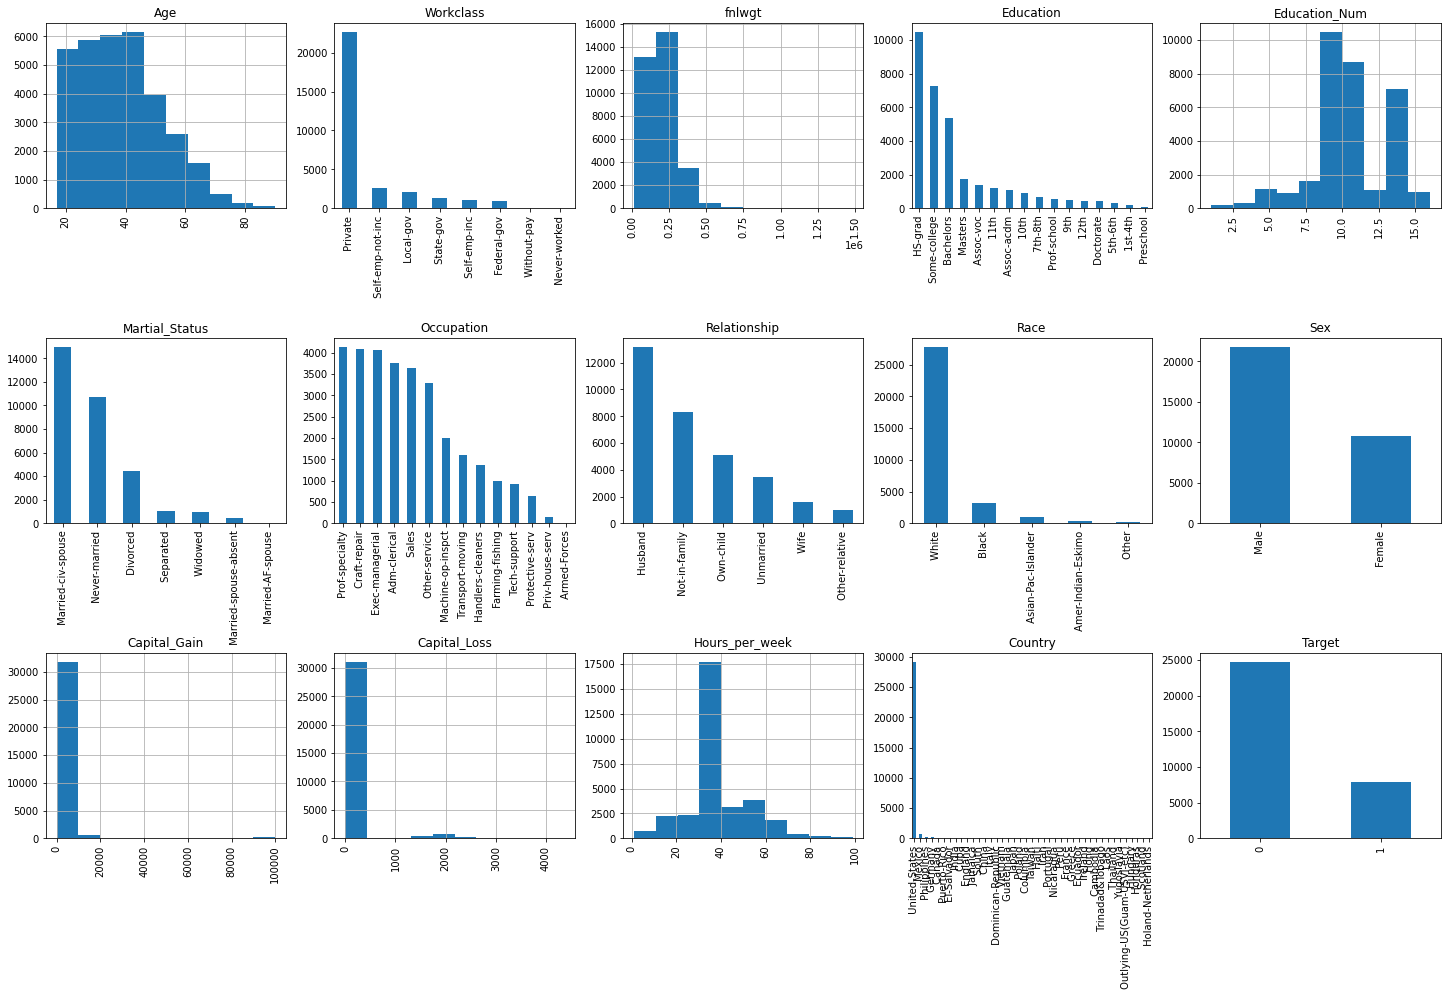

In [10]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [11]:
#Checking Data types
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [12]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [0]:
# We want these to be int(s)
data_test['Age'] = data_test['Age'].astype(int)
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [14]:
# Seperate Numerical data and Categorical Data
categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [16]:
# Resolving missing data
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [0]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [18]:
print(set(data_train.columns) - set(data_test.columns) )
data_train.shape, data_test.shape

{'Country_ Holand-Netherlands'}


((32561, 106), (16281, 105))

In [0]:
data_test['Country_ Holand-Netherlands'] = 0
set(data_train.columns) - set(data_test.columns)
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

# K-Nearest Neighbor

In [56]:

from sklearn.pipeline import Pipeline
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 18.1min finished


({'knn__n_neighbors': 8}, 0.8275546006833432)

In [66]:
knn_pred = knn_grid.predict(X_test)
print(f"KNN accuracy score: {accuracy_score(y_test, knn_pred)*100}%")

KNN accuracy score: 76.4756464590627%


# Decision Tree

In [0]:
# Save Decision Tree Diagram to a png 
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save, class_name):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None , class_names = class_name)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [58]:
# 5-Fold Cross Validation
tree_params = {'max_depth': range(2,11)}
tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, verbose = True , n_jobs = -1 , cv  = 5)                    
tree.fit(X_train, y_train);
tree.best_params_, tree.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.9s finished


({'max_depth': 9}, 0.8565770273854106)

In [0]:
# Train tuned tree w/ best parameters
tuned_tree = DecisionTreeClassifier( max_depth= 9 , random_state= 17)
tuned_tree.fit(X_train, y_train)
class_name = ["<=50K", ">50K"]
tree_graph_to_png(tuned_tree, X_train.columns, 'tree', class_name)

<img src = '/content/tree'>

In [60]:
tree_predictions = tuned_tree.predict(X_test)
print(f"Decision tree accuracy: {accuracy_score(y_test, tree_predictions)*100}%")

Decision tree accuracy: 84.77980468030219%


# Random Forest

In [62]:
forest_params = {'max_depth': range(10, 16),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(n_estimators=10, random_state=17,
                           n_jobs=-1),
    forest_params, cv=3, verbose=1)

locally_best_forest.fit(X_train, y_train)
locally_best_forest.best_params_,locally_best_forest.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   58.0s finished


({'max_depth': 14, 'max_features': 45}, 0.8619822161458556)

In [70]:
tuned_rf = RandomForestClassifier(n_estimators = 10 , max_depth  =13 , max_features = 85 , random_state = 17)
tuned_rf.fit(X_train , y_train)
tuned_forest_pred= tuned_rf.predict(X_test)
print (f"Random Forest accuracy: {accuracy_score(y_test , tuned_forest_pred)*100}%")

Random Forest accuracy: 86.20477857625453%


# Neural Network 

In [154]:
current_time = utc_timezone.localize(datetime.now()).astimezone(pacific_timezone).strftime("%H:%M:%S")
run = wandb.init(project="uci_adult", group="Ryan", name="Ryan - "+current_time)
y_trainNN = np_utils.to_categorical(y_train)
y_testNN = np_utils.to_categorical(y_test)



In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(12, activation='sigmoid', input_dim=105))
  model.add(Dense(2, activation='sigmoid', input_dim=12))
  model.add(Dense(num_classes, activation="softmax"))     # Output layer
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  #Save model to W&B
  model.save(os.path.join(wandb.run.dir, "model.h5"))
  return model

In [157]:
model = create_model()
model.fit(X_train, y_trainNN, validation_data=(X_test, y_testNN), epochs=8,verbose=True)
model.summary()

#  callbacks=[WandbCallback()],

Epoch 1/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5585 - accuracy: 0.7592 - val_loss: 0.5465 - val_accuracy: 0.7638
Epoch 2/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5519 - accuracy: 0.7592 - val_loss: 0.5463 - val_accuracy: 0.7638
Epoch 3/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5518 - accuracy: 0.7592 - val_loss: 0.5462 - val_accuracy: 0.7638
Epoch 4/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5518 - accuracy: 0.7592 - val_loss: 0.5467 - val_accuracy: 0.7638
Epoch 5/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5517 - accuracy: 0.7592 - val_loss: 0.5461 - val_accuracy: 0.7638
Epoch 6/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7592 - val_loss: 0.5460 - val_accuracy: 0.7638
Epoch 7/8
1018/1018 [==============================] - 2s 2ms/step - loss: 0.5514 - accuracy: 0.7592 - val_loss: 0.5459 - val_accuracy: 0.7638

In [158]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Keras evaluation result:", round(score[0],2))
print(f"Percentage right: {round(score[1]*100 , 2)}%.")

509/509 [==============================] - 1s 1ms/step - loss: 0.8736 - accuracy: 1.0000
Keras evaluation result: 0.87
Percentage right: 100.0%.
